In [1]:
#%pip install -i https://test.pypi.org/simple --extra-index-url https://pypi.org/simple tramdag

In [2]:
import os
from tramdag import TramDagModel, TramDagConfig
import warnings
warnings.filterwarnings("ignore", module="torchvision")

In [3]:
#TramDagModel.from_directory(EXPERIMENT_DIR='exp_untrained') #Loading the model from the experiment directory

In [4]:
cfg=TramDagConfig()
cfg.setup_configuration(EXPERIMENT_DIR='exp_traind_treament_ord') # works also without arguments, then default paths are used

Configuration already exists: exp_traind_treament_ord/configuration.json


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import pandas as pd
import numpy as np
np.random.seed(43)
# Ja, sag mal, X1 ist uniform verteilt zwischen 0 und 2.
# T Modelliert als logistische Regression in Abhängigkeit von x1 mit dem Koeffizienten 2. 
# x2 ist normalverteilt mit Mittelwert 0 und Standardabweichung 1.
n = 10_000
x1 = np.random.uniform(0, 2, size=(n, 1))
T = np.random.binomial(1, 1 / (1 + np.exp(-2 * x1)))
x2 = -1*T + np.random.normal(0,0.1, size=(n, 1))
y = 4*T + 2*x2 + 3*x1 + np.random.normal(0, 0.1, size=(n, 1))
df = pd.DataFrame({'x1': x1.flatten(), 'T': T.flatten(), 'x2': x2.flatten(), 'y': y.flatten()})

print(df.head())


# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

         x1  T        x2         y
0  0.230109  1 -0.970318  2.711701
1  1.218133  1 -0.981813  5.735994
2  0.266782  1 -1.133603  2.535317
3  0.481179  1 -1.133444  3.004933
4  0.654278  1 -1.156792  3.559691


In [6]:
# here you need to specify which varibles are in the graph and what type they are (continous or ordinal) for the model builder 
data_type= {'x1':'continous',
            'T':'ordinal_Xc_Yo', 
            'x2':'continous',
            'y':'continous'} 

cfg.set_data_type(data_type)

---------------------------------------------------------------------------------------------------------
                                       |                       MODEL SETTINGS                       
Variable             | dtype           | As Predictor                   | As Target                     
---------------------------------------------------------------------------------------------------------
x1                   | continous       | continuous [c]                 | continuous [c]                
T                    | ordinal_Xc_Yo   | continuous [c]                 | ordinal    [0,…,K]            
x2                   | continous       | continuous [c]                 | continuous [c]                
y                    | continous       | continuous [c]                 | continuous [c]                
---------------------------------------------------------------------------------------------------------
Configuration updated successfully at exp_traind_treamen

/home/bule/TramDag/tramdag/utils/configuration.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


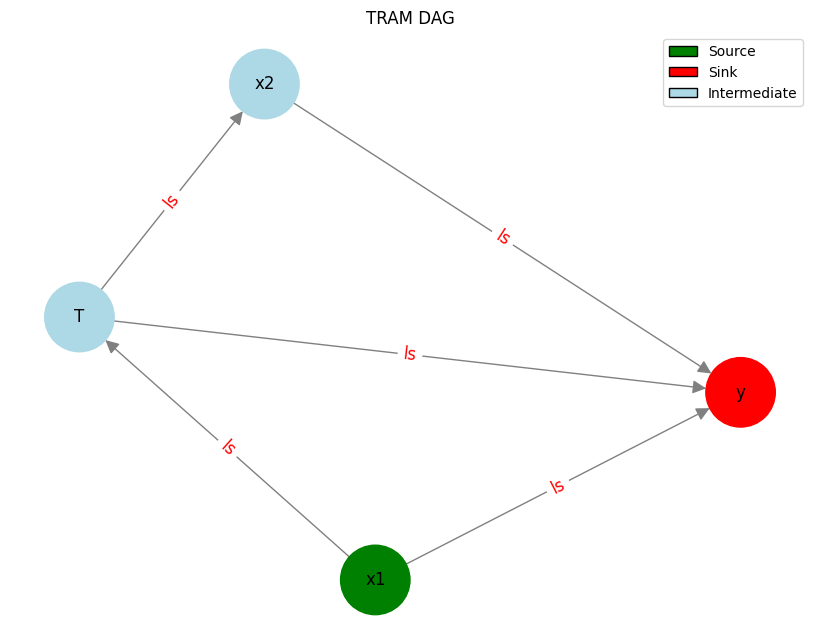

In [7]:
cfg.set_meta_adj_matrix(seed=123) #Create the (Meta) Adjacency Matrix

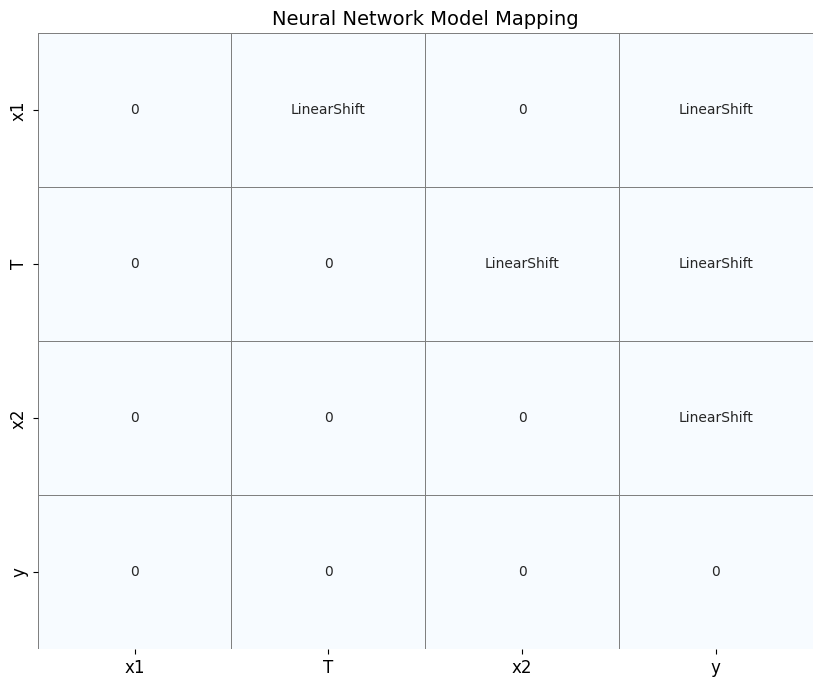

In [8]:
cfg.set_tramdag_nn_models() 
#Create the NN models one per node
# Create names for the models, which then can be to define different architectures for different nodes

All is in the configuration file now, so we delete cfg and load the configuration file

In [9]:
cfg.compute_levels(train_df)

In [10]:
from tramdag import TramDagModel
device='cpu'
td_model = TramDagModel.from_config(cfg, set_initial_weights=True,verbose=True,debug=False,device=device,initial_data =train_df )
# Created the model from the configuration
# If weight initialization is set to True then R code like Polar... is used to initialize the weights

[INFO] Initialized intercept model with preinitialized weights: SimpleIntercept(
  (fc): Linear(in_features=1, out_features=20, bias=False)
)
[INFO] Initialized intercept model with preinitialized weights: SimpleIntercept(
  (fc): Linear(in_features=1, out_features=1, bias=False)
)
[INFO] Initialized intercept model with preinitialized weights: SimpleIntercept(
  (fc): Linear(in_features=1, out_features=20, bias=False)
)
[INFO] Initialized intercept model with preinitialized weights: SimpleIntercept(
  (fc): Linear(in_features=1, out_features=20, bias=False)
)


In [12]:
epochs = 2000

td_model.fit(train_df, val_df,
#  train_list=['y'], #Training only on a subset of the model
    learning_rate=10e-2,
    epochs=epochs,batch_size=1000,
    verbose=True,debug=False,
    device=device,
    num_workers = 8,
    persistent_workers = True,
    prefetch_factor = 8,       #For DataLoader
    train_mode = "sequential") #Parallel is better for many nodes


[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to exp_traind_treament_ord/min_max_scaling.json
[INFO] Training 4 nodes (sequential) on cpu

[INFO] Training node 'x1' for 2000 epochs on cpu (pid=3183905)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training node 'T' for 2000 epochs on cpu (pid=3183905)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training node 'x2' for 2000 epochs on cpu (pid=3183905)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training node 'y' for 2000 epochs on cpu (pid=3183905)
[INFO] No existing trained model found.
 Starting fresh...

===== Epoch 1/2000 =====


[INFO] Saved linear shift weights for epoch 1 -> exp_traind_treament_ord/y/linear_shifts_all_epochs.json
[INFO] Saved simple intercept weights for epoch 1 -> exp_traind_treament_ord/y/simple_intercepts_all_epochs.json
[INFO] Saved new best model.
[INFO] Epoch 1: Train NLL=-0.7832 | Val NLL=-0.7770 | Time=0.61s

===== Epoch 2/2000 =====
[INFO] Saved linear shift weights for epoch 2 -> exp_traind_treament_ord/y/linear_shifts_all_epochs.json
[INFO] Saved simple intercept weights for epoch 2 -> exp_traind_treament_ord/y/simple_intercepts_all_epochs.json
[INFO] Saved new best model.
[INFO] Epoch 2: Train NLL=-0.7869 | Val NLL=-0.7785 | Time=0.25s

===== Epoch 3/2000 =====
[INFO] Saved linear shift weights for epoch 3 -> exp_traind_treament_ord/y/linear_shifts_all_epochs.json
[INFO] Saved simple intercept weights for epoch 3 -> exp_traind_treament_ord/y/simple_intercepts_all_epochs.json
[INFO] Epoch 3: Train NLL=-0.7874 | Val NLL=-0.7779 | Time=0.22s

===== Epoch 4/2000 =====
[INFO] Saved li

[INFO] Loaded training/validation histories for 4 nodes.


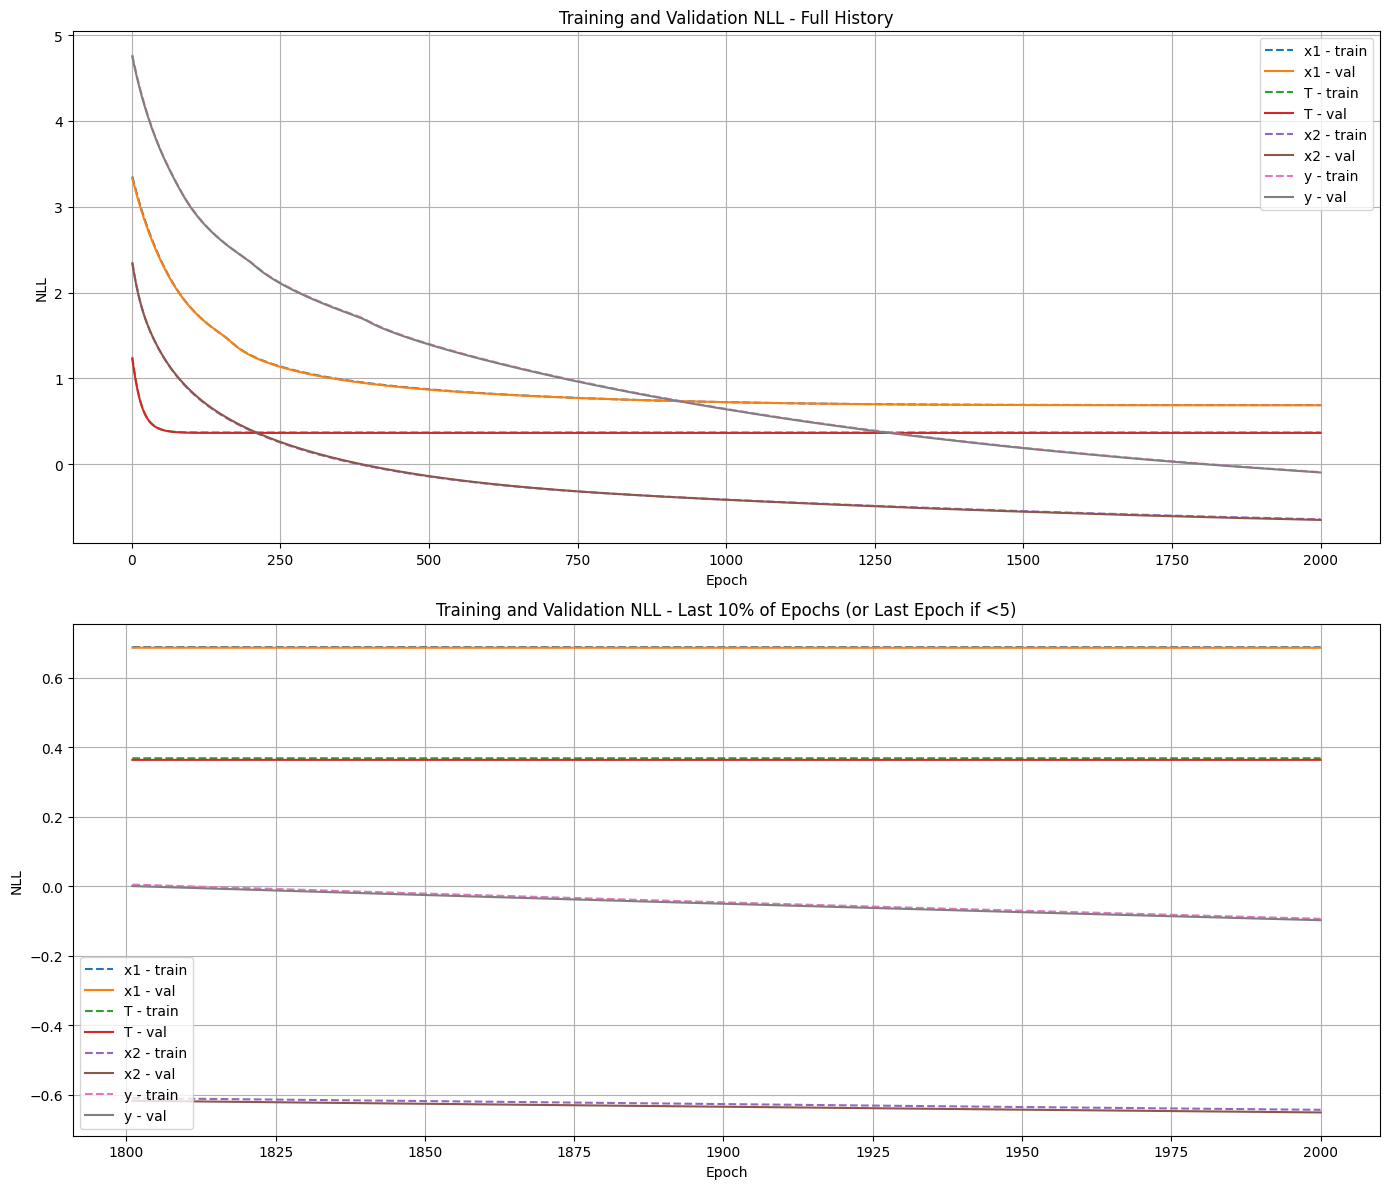

In [ ]:
td_model.plot_loss_history()

[WARNING] No linear shift history found for node 'x1' at exp_traind_treament_ord/x1/linear_shifts_all_epochs.json


/home/bule/TramDag/tramdag/TramDagModel.py:942: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(flatten)


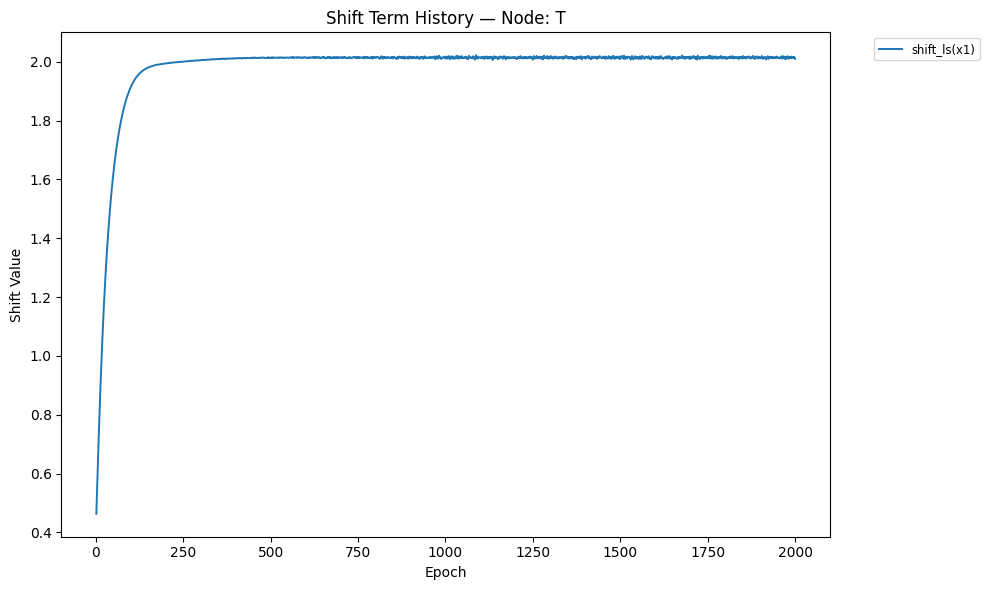

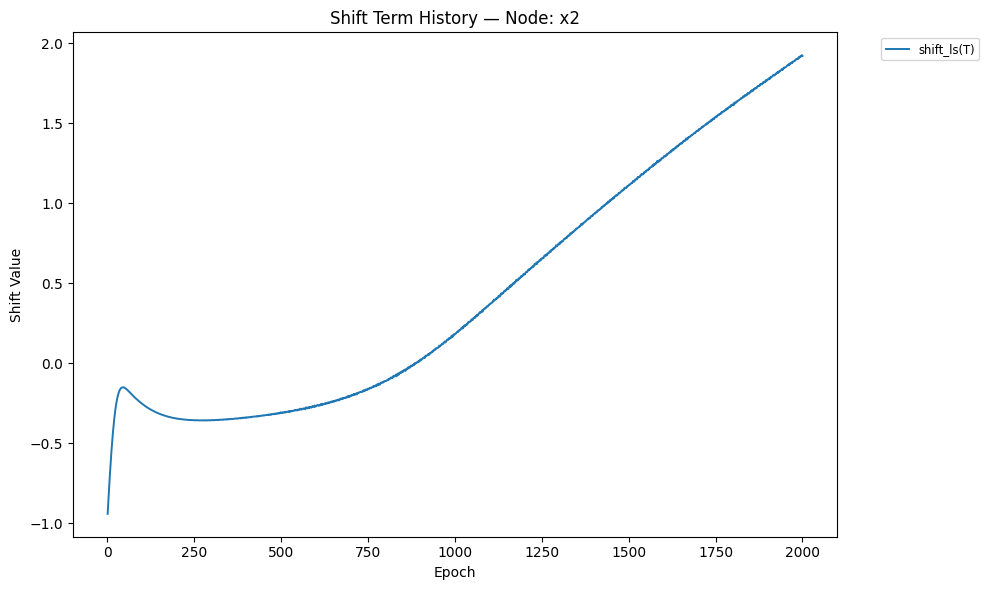

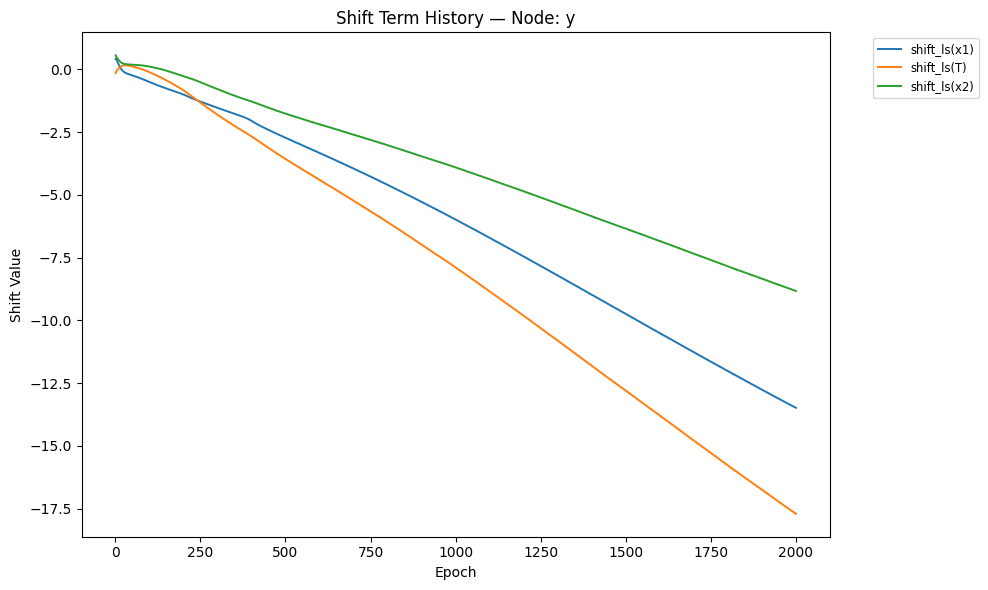

In [ ]:
td_model.plot_linear_shift_history()

/Users/oli/Documents/GitHub/TramDag/tramdag/TramDagModel.py:992: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(extract_scalar)


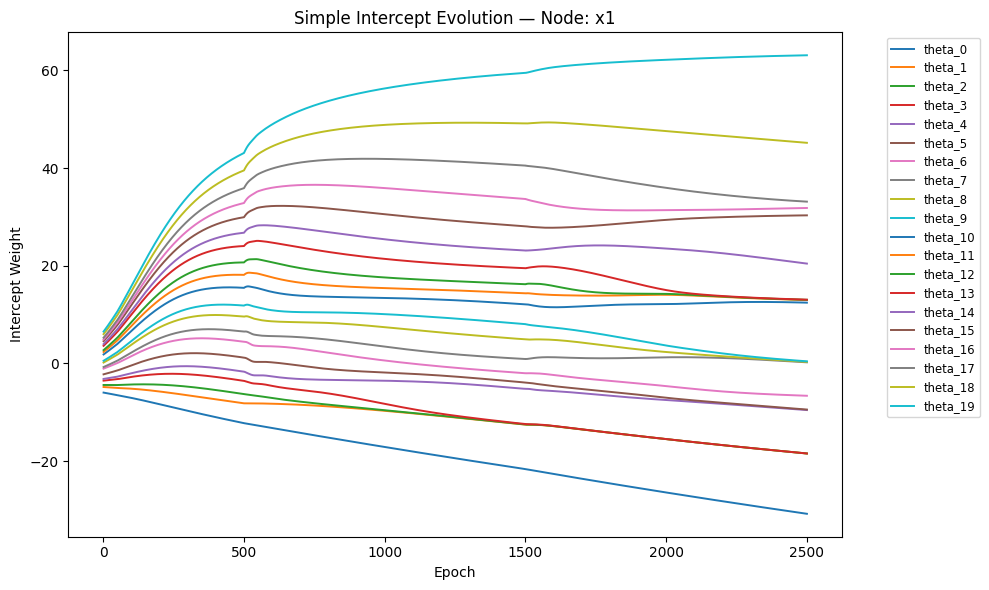

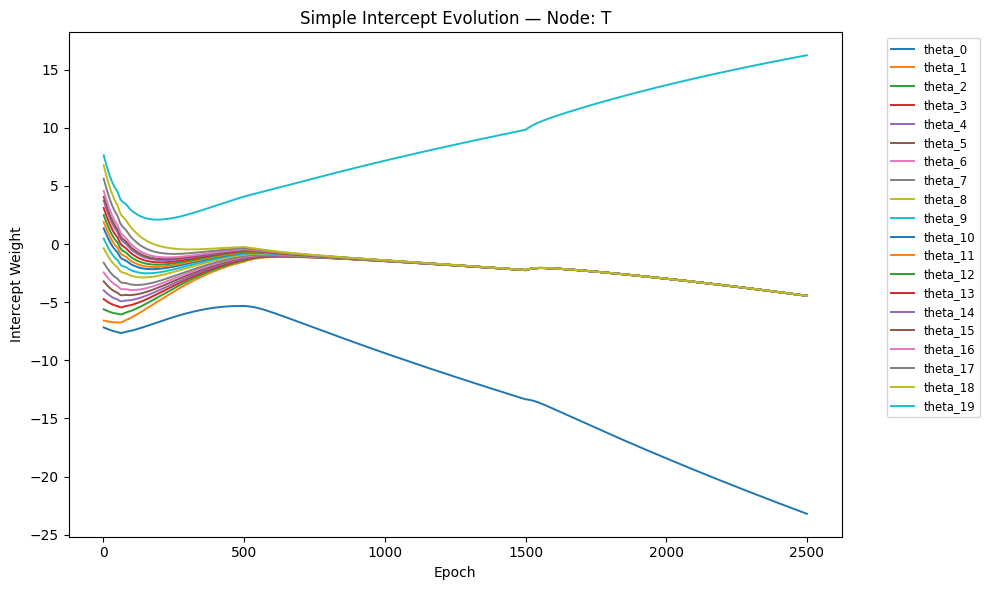

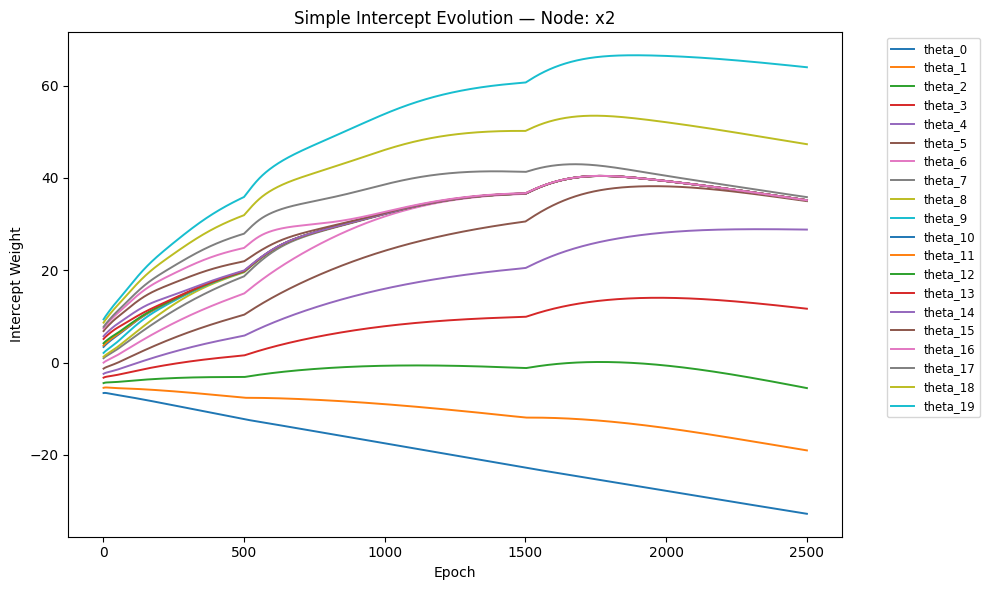

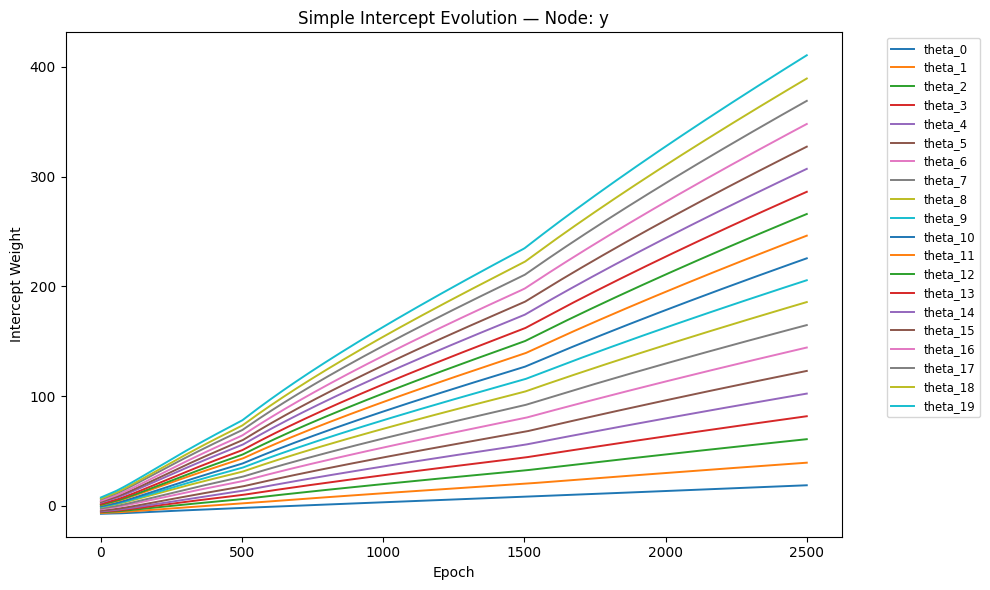

In [ ]:
td_model.plot_simple_intercepts_history()

In [ ]:
td_model.load_or_compute_minmax(train_df)

[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to exp_traind_treament_ord/min_max_scaling.json


In [ ]:
td_model.plot_samples_vs_true(df=train_df)

[WARNING] skip x1: exp_traind_treament_ord/x1/sampling/sampled.pt not found.
[WARNING] skip T: exp_traind_treament_ord/T/sampling/sampled.pt not found.
[WARNING] skip x2: exp_traind_treament_ord/x2/sampling/sampled.pt not found.
[WARNING] skip y: exp_traind_treament_ord/y/sampling/sampled.pt not found.


In [ ]:
td_model.sample(do_interventions={'T':1.0}, predefined_latent_samples_df=u_test_T0)

[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Interventions specified for nodes: ['T']
[INFO] Using predefined latents samples from dataframe -> therefore n_samples is set to the number of rows in the dataframe: 20
[INFO] Deleting all previously sampled data.
Deleted directory: exp_untrained/x1/sampling
Deleted directory: exp_untrained/T/sampling
Deleted directory: exp_untrained/x2/sampling
Deleted directory: exp_untrained/y/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x1 from dataframe column: x1_U


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 2931.15it/s]

[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: T ------------*-----------------*-------------------*--
[INFO] Applying intervention for node 'T' with value 1.0
[INFO] Interventional data for node T is saved

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x2 from dataframe column: x2_U



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 2621.44it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: y ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node y from dataframe column: y_U



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 2880.53it/s]

[INFO] Completed sampling for node 'y'
[INFO] DAG sampling completed successfully for all nodes.


({'x1': tensor([0.5368, 0.3087, 0.5006, 1.3407, 0.2469, 0.3962, 0.7639, 0.4667, 0.2954,
          0.8744, 0.4184, 1.1731, 0.3132, 0.8151, 0.8925, 0.4014, 1.0097, 0.2962,
          0.5954, 0.4965]),
  'T': tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1.]),
  'x2': tensor([-0.7093, -0.7272, -0.0490, -0.7925, -0.5444, -0.0512, -0.6214, -0.0830,
          -0.8096, -0.1286, -0.2244, -0.7277, -0.7235, -0.0737, -0.6475, -0.2192,
          -0.7874, -0.8053, -0.1007, -0.7747]),
  'y': tensor([4.0123, 3.2032, 5.1367, 6.1474, 3.4144, 4.8650, 4.8184, 5.0268, 3.0457,
          6.0496, 4.6231, 5.8054, 3.2369, 6.0130, 5.1856, 4.5676, 5.2888, 3.0293,
          5.3183, 3.6857])},
 {'x1': tensor([-0.2611, -0.5933, -0.3152,  1.0430, -0.6826, -0.4689,  0.0877, -0.3655,
          -0.6122,  0.2655, -0.4366,  0.7486, -0.5870,  0.1696,  0.2950, -0.4614,
           0.4850, -0.6110, -0.1729, -0.3212]),
  'T': tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, n

In [ ]:
s[0]['y'].numpy().flatten()

KeyError: 0

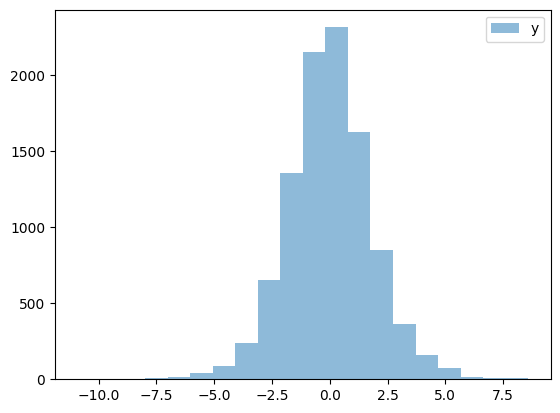

In [ ]:
#Make a histogram of the samples y
plt.hist(s[1]['y'].numpy().flatten(), bins=20, alpha=0.5, label='y')
plt.legend()
plt.show()



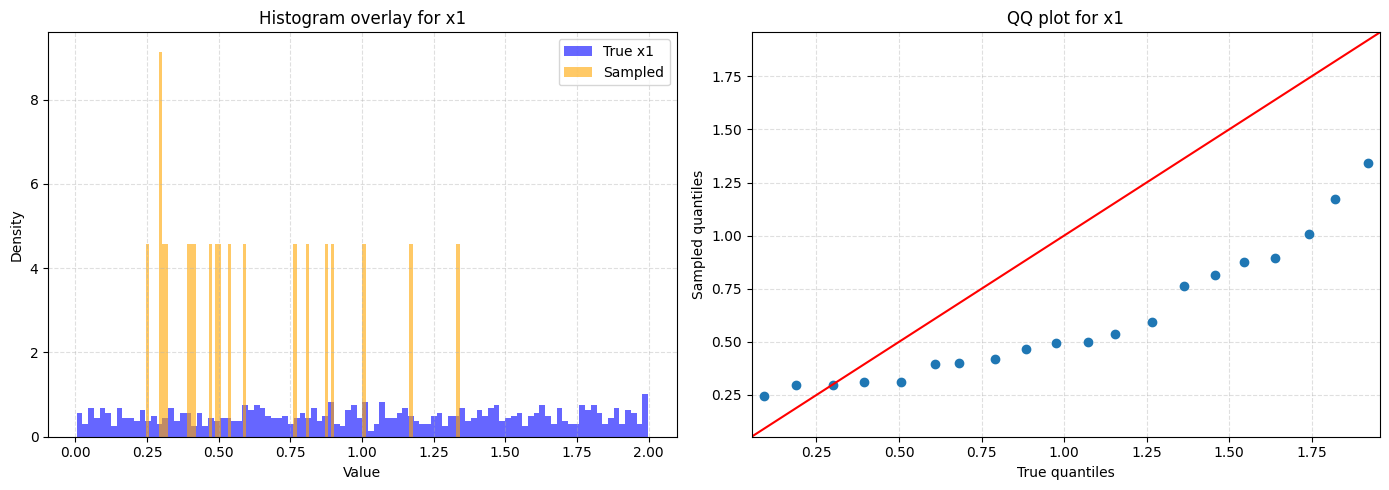

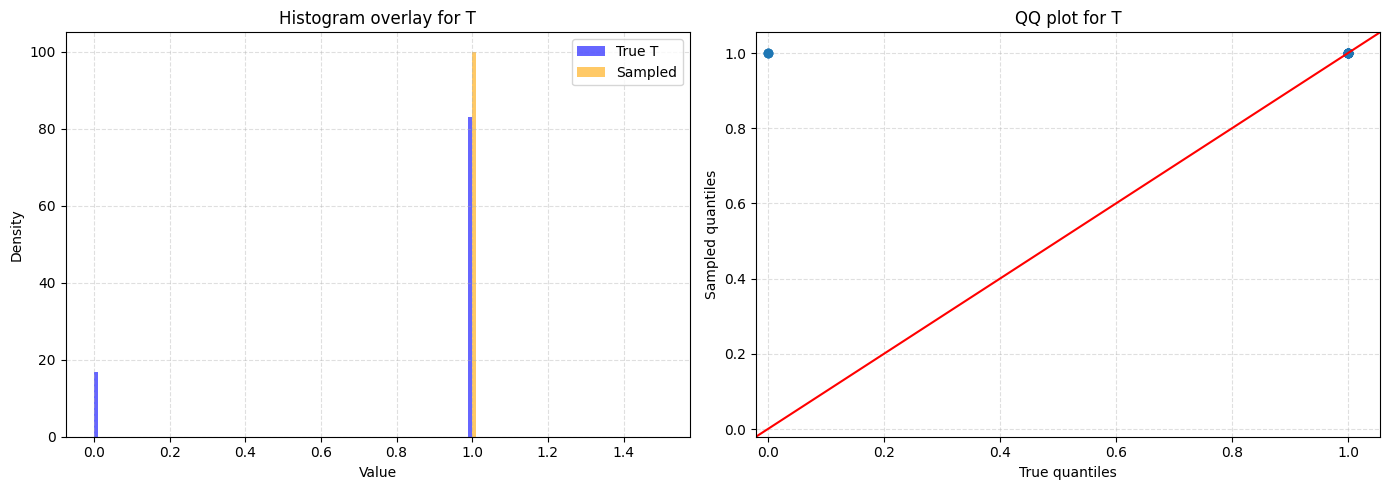

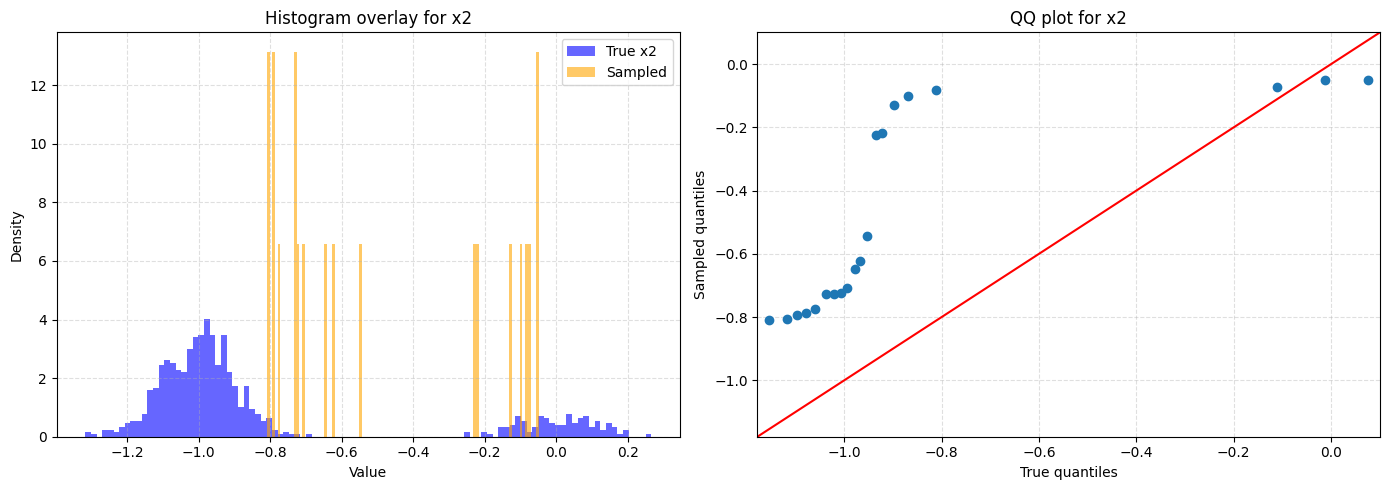

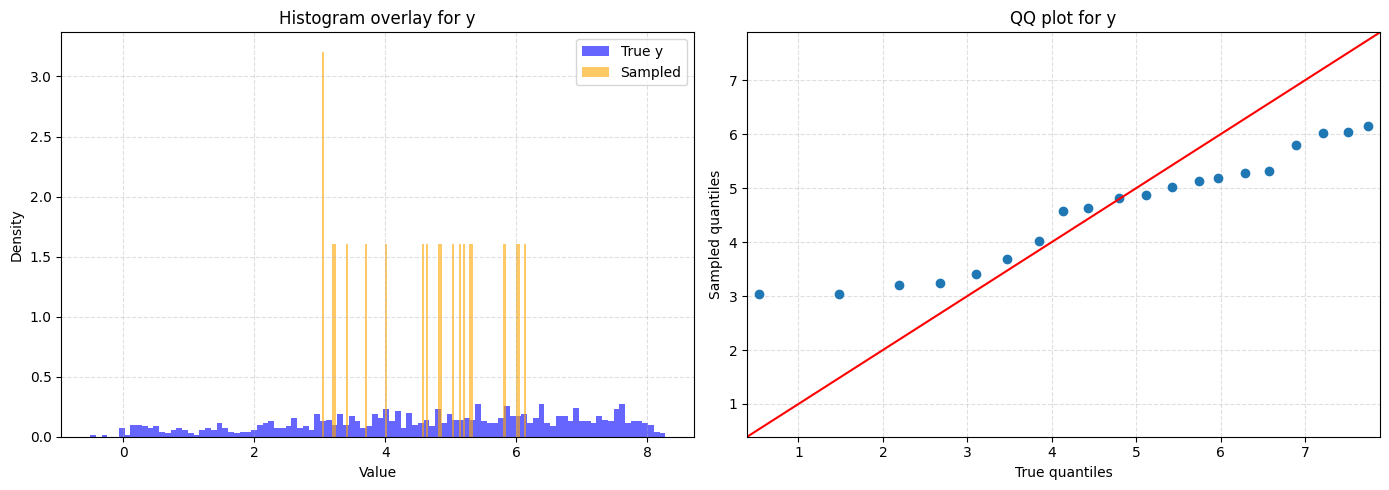

In [ ]:
td_model.plot_samples_vs_true(train_df)

[INFO] Final latent DataFrame shape: (800, 8)


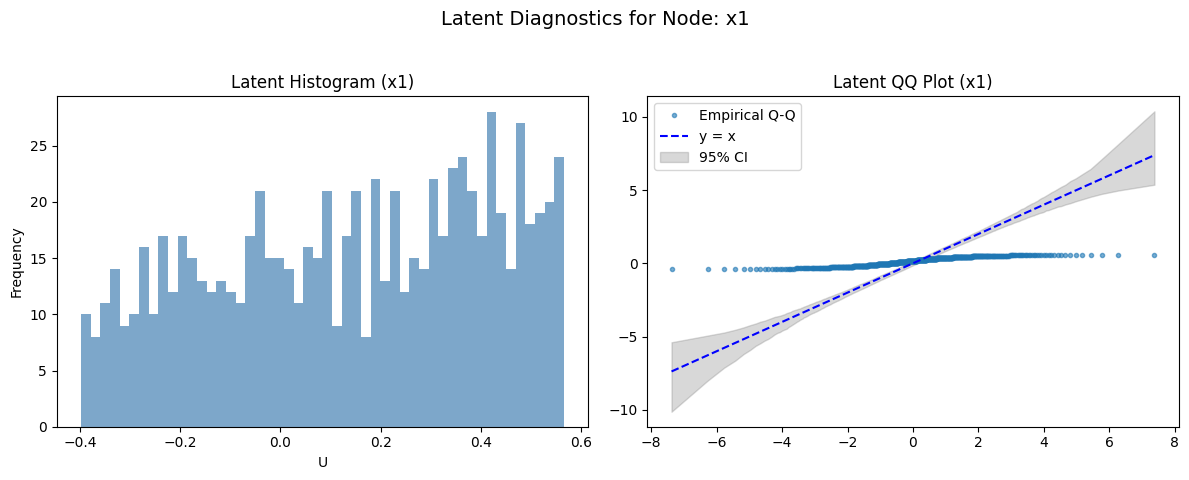

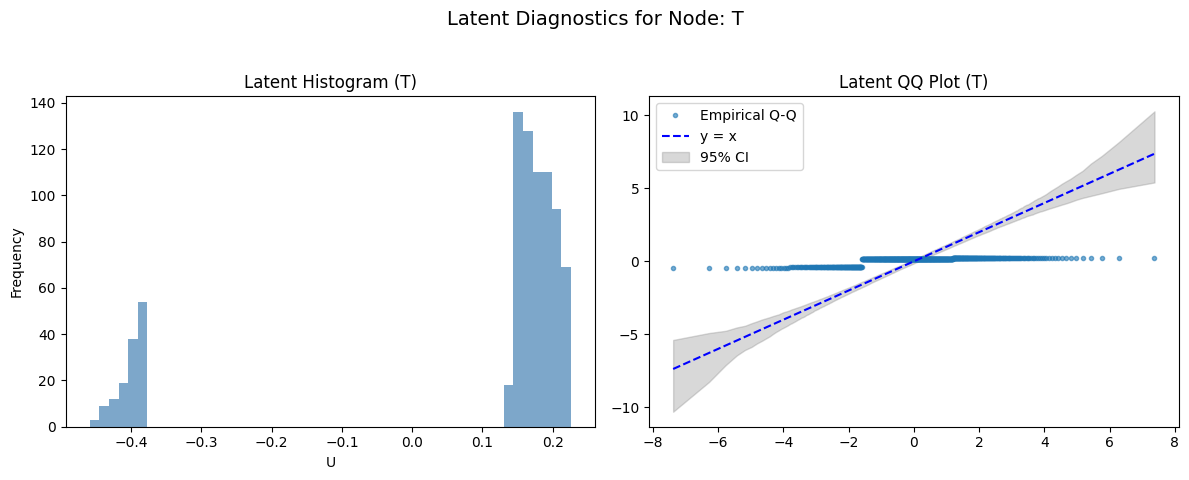

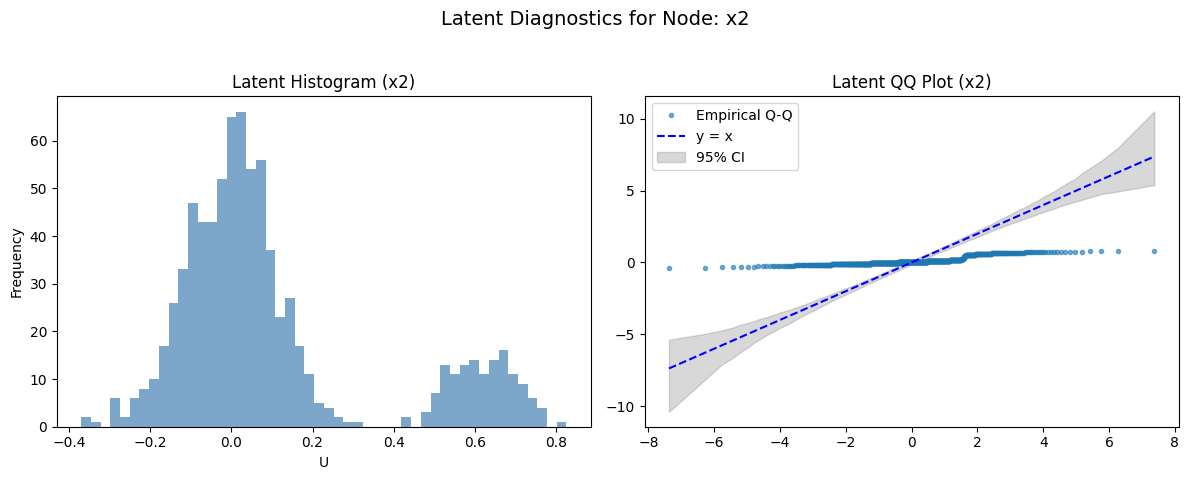

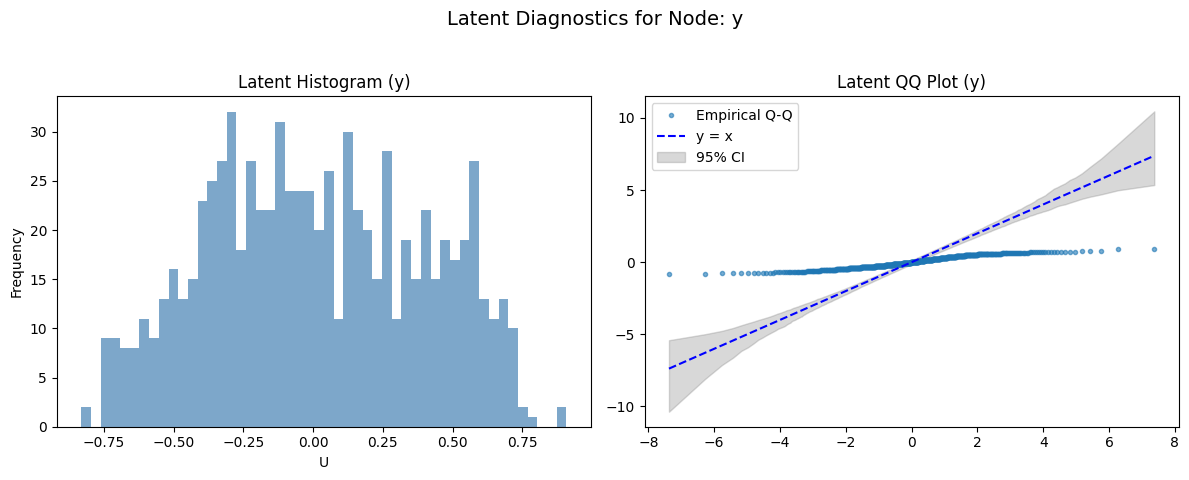

In [ ]:
td_model.plot_latents(train_df)

In [ ]:
u_training.head()

,x1,x1_U,T,T_U,x2,x2_U,y,y_U
55,0.798394,-0.136223,0,-0.687904,-0.149715,0.195087,2.052128,-0.076949
88,0.010167,-0.429019,0,-0.341520,0.088570,0.308551,0.213088,-0.311112
26,0.165000,-0.374579,0,-0.409561,0.033188,0.292422,0.504235,-0.282418
42,1.730034,0.247642,1,-0.384391,-1.018699,0.532360,7.105176,0.059292
69,0.486796,-0.251359,0,-0.550973,0.090682,0.309166,1.571181,-0.120555


In [ ]:
u_training = td_model.get_latent(train_df)

[Warning] best_model.pt not found, falling back to initial_model.pt


/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <EA7F9DF5-8854-31D8-89D4-BD566CAF4DEA> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <B6BD92AE-4D03-3F92-9E03-2E2594A12866> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your e

[Warning] best_model.pt not found, falling back to initial_model.pt


/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <EA7F9DF5-8854-31D8-89D4-BD566CAF4DEA> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <B6BD92AE-4D03-3F92-9E03-2E2594A12866> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extens

[Warning] best_model.pt not found, falling back to initial_model.pt


/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <EA7F9DF5-8854-31D8-89D4-BD566CAF4DEA> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <B6BD92AE-4D03-3F92-9E03-2E2594A12866> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extens

[Warning] best_model.pt not found, falling back to initial_model.pt


/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <EA7F9DF5-8854-31D8-89D4-BD566CAF4DEA> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <B6BD92AE-4D03-3F92-9E03-2E2594A12866> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extens

[INFO] Final latent DataFrame shape: (80, 8)


In [ ]:
samples, latents = td_model.sample(predefined_latent_samples_df=u_training)
#samples, latents = td_model.sample()
assert(sum(latents['y'].numpy().flatten()  != np.array(u_training.y_U).flatten()),0) #check pd sucks

[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Using predefined latents samples from dataframe -> therefore n_samples is set to the number of rows in the dataframe: 800
[INFO] Deleting all previously sampled data.
Deleted directory: exp_untrained/x1/sampling
Deleted directory: exp_untrained/T/sampling
Deleted directory: exp_untrained/x2/sampling
Deleted directory: exp_untrained/y/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x1 from dataframe column: x1_U


<>:3: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:3: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/Users/oli/Documents/GitHub/tramdag_py/.conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 1964.44it/s]

[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: T ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node T from dataframe column: T_U



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 1936.52it/s]

[INFO] Completed sampling for node 'T'

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x2 from dataframe column: x2_U



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 1767.13it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: y ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node y from dataframe column: y_U



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 1899.55it/s]

[INFO] Completed sampling for node 'y'
[INFO] DAG sampling completed successfully for all nodes.



/var/folders/bk/0vv7sh9n43n3dm4fth1qw93r0000gq/T/ipykernel_24390/4176051791.py:3: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(sum(latents['y'].numpy().flatten()  != np.array(u_training.y_U).flatten()),0) #check pd sucks


In [ ]:
(train_df['x2']-samples['x2'].numpy().flatten())/train_df['x2']







29    -5.390176e-08
535    2.224215e-05
695   -2.552234e-06
557   -1.400964e-07
836    1.308436e-05
           ...     
106   -1.479647e-07
270    1.177148e-07
860   -6.184249e-09
435    3.935214e-05
102   -1.830173e-07
Name: x2, Length: 800, dtype: float64

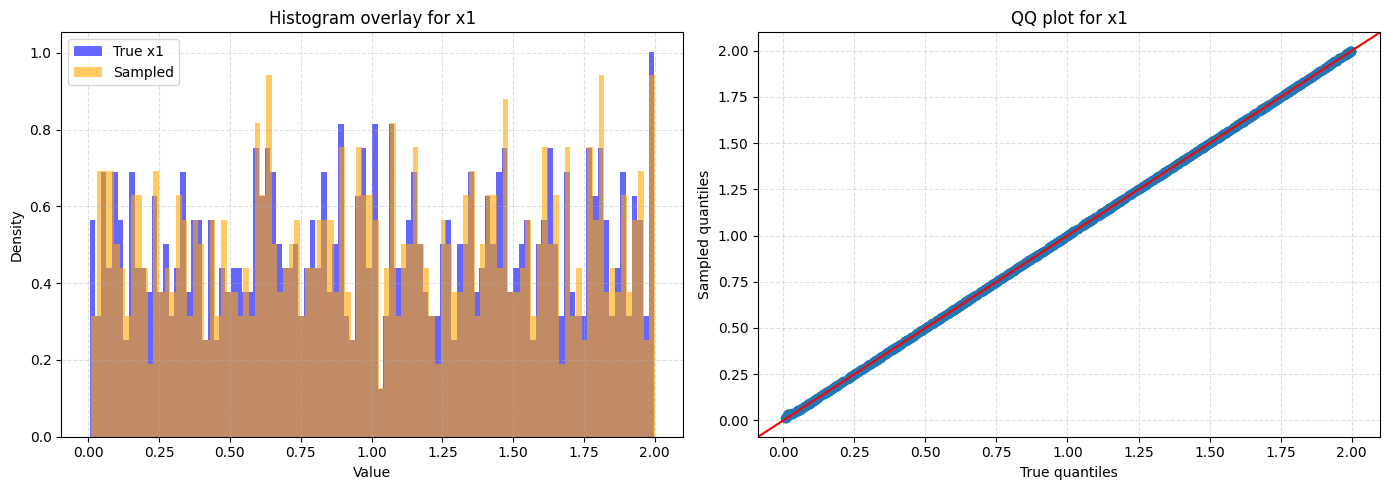

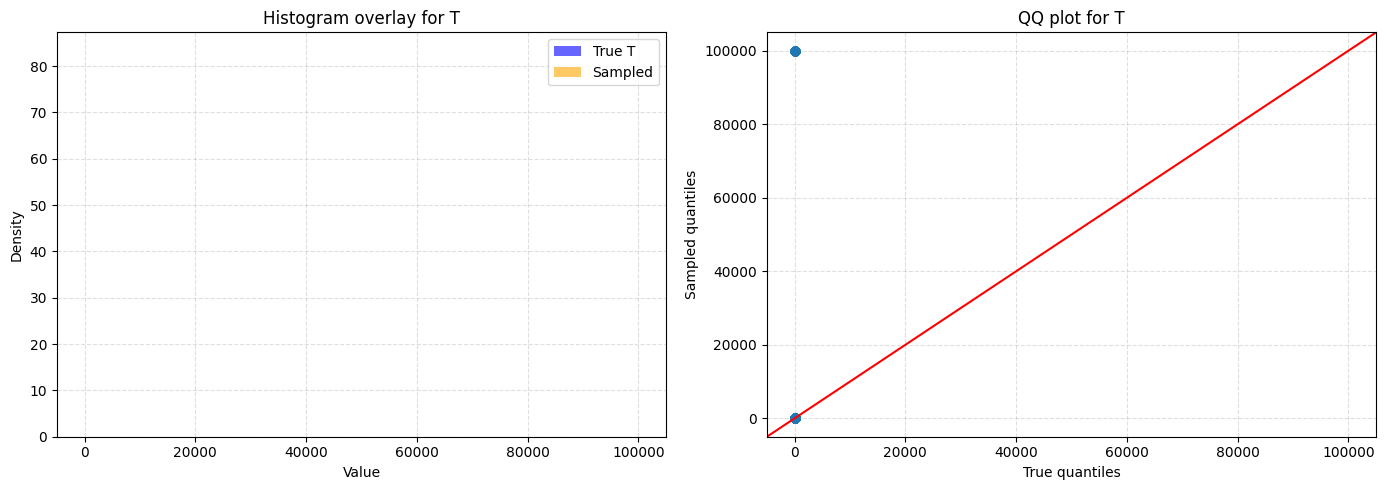

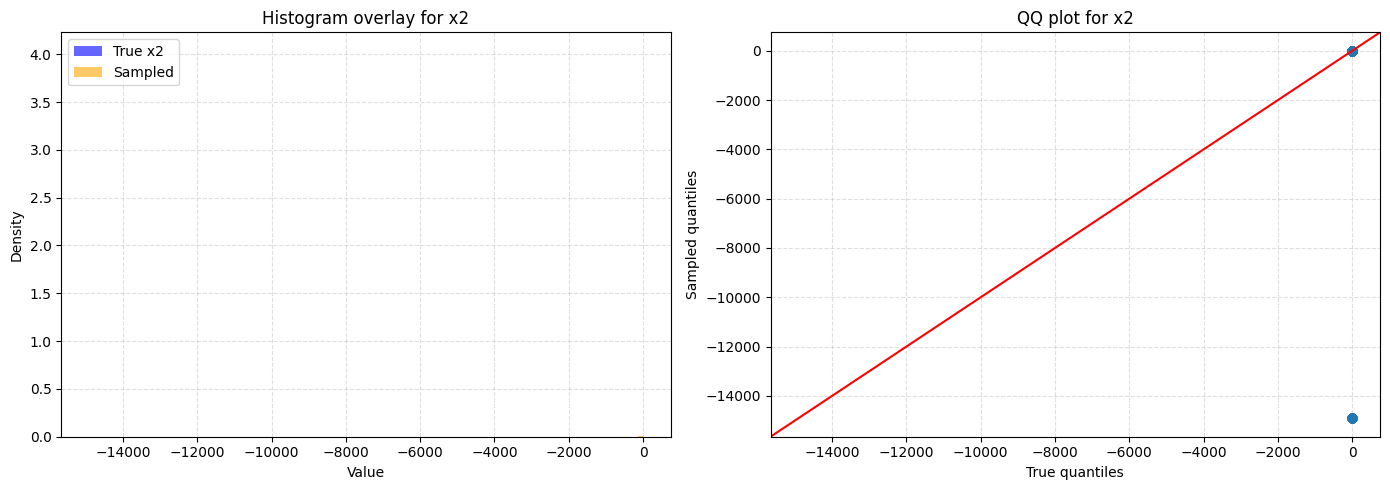

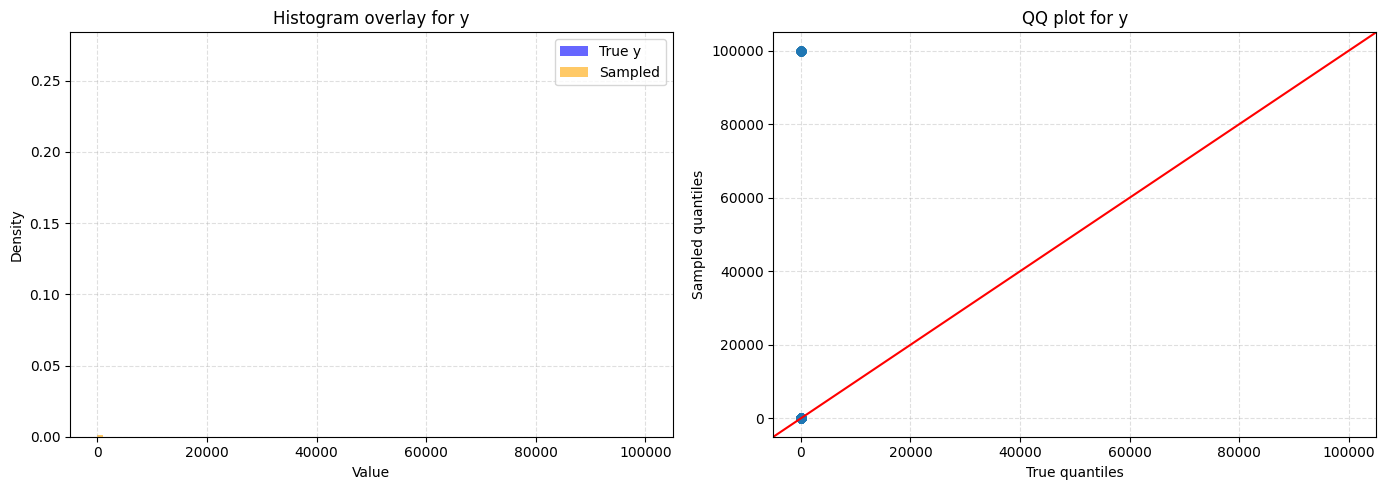

In [ ]:
td_model.plot_samples_vs_true(df=train_df, sampled=samples)

plots the DAG for the variables y using X,Y... from row=`plot_n_rows` of train df

[WARNING] len(df)>1, set: plot_n_rows accordingly
[Warning] best_model.pt not found, falling back to initial_model.pt


/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <EA7F9DF5-8854-31D8-89D4-BD566CAF4DEA> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <B6BD92AE-4D03-3F92-9E03-2E2594A12866> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extens


=== Sample 1/3 ===
x1    0.798394
T     0.000000
x2   -0.149715
y     2.052128
Name: 55, dtype: float64


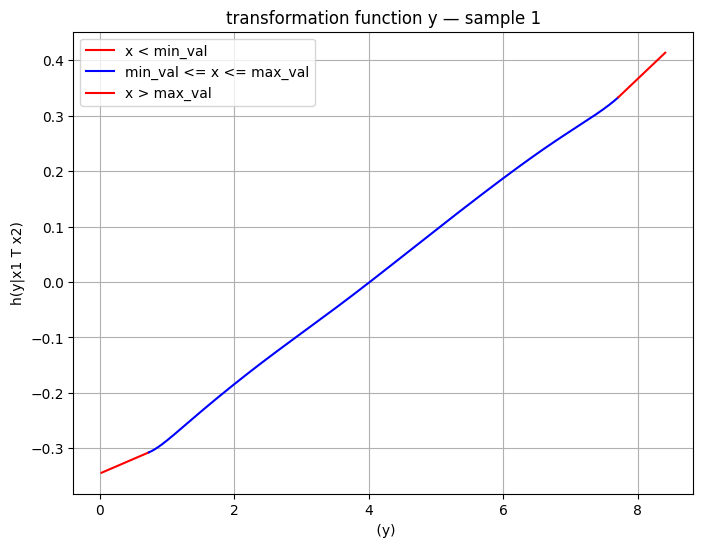


=== Sample 2/3 ===
x1    0.010167
T     0.000000
x2    0.088570
y     0.213088
Name: 88, dtype: float64


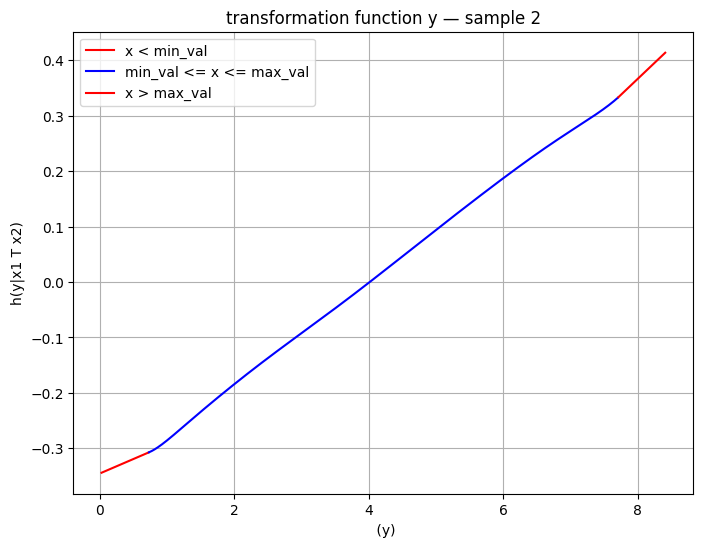


=== Sample 3/3 ===
x1    0.165000
T     0.000000
x2    0.033188
y     0.504235
Name: 26, dtype: float64


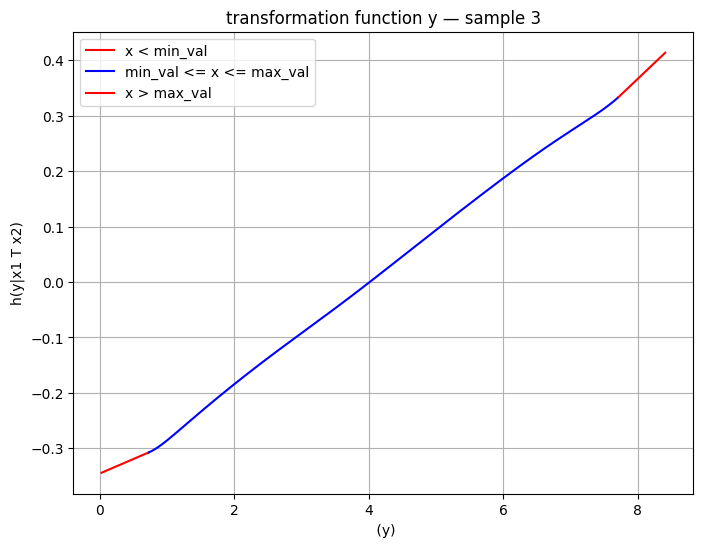

In [ ]:
td_model.plot_hdag(train_df,variables=['y'],plot_n_rows=3) 

In [ ]:
td_model.nll(val_df)

/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <EA7F9DF5-8854-31D8-89D4-BD566CAF4DEA> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <B6BD92AE-4D03-3F92-9E03-2E2594A12866> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extens

{'x1': 2.257230520248413,
 'T': 2.4604687690734863,
 'x2': 1.9448314905166626,
 'y': 3.757701873779297}

In [ ]:
td_model.nll(train_df)

/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <EA7F9DF5-8854-31D8-89D4-BD566CAF4DEA> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <B6BD92AE-4D03-3F92-9E03-2E2594A12866> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extens

{'x1': 2.310797929763794,
 'T': 2.4474384784698486,
 'x2': 2.0221168994903564,
 'y': 3.7699496746063232}

In [ ]:
td_model.summary(verbose=True)


                                                 TRAM DAG MODEL SUMMARY                                                 

[1] TRAINING METRICS OVERVIEW
------------------------------------------------------------------------------------------------------------------------
     Node      Best Train NLL  Best Val NLL  Last Train NLL  Last Val NLL      Epochs    
      x1            None           None           None           None            0       
       T            None           None           None           None            0       
      x2            None           None           None           None            0       
       y            None           None           None           None            0       
------------------------------------------------------------------------------------------------------------------------

[2] NODE-SPECIFIC DETAILS
------------------------------------------------------------------------------------------------------------------------

      

In [ ]:
############### !!!!!!!!!!!!!!!!!!!!!!!!! #######################################################
u_training = td_model.get_latent(train_df)
samples_doT1, latents_doT1 = td_model.sample(do_interventions={'T':1.0}, predefined_latent_samples_df=u_training)
#################################################################################################

/Users/oli/Documents/GitHub/tramdag_py/.conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[INFO] Final latent DataFrame shape: (800, 8)
[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Interventions specified for nodes: ['T']
[INFO] Using predefined latents samples from dataframe -> therefore n_samples is set to the number of rows in the dataframe: 800
[INFO] Deleting all previously sampled data.
Directory does not exist: exp_untrained/x1/sampling
Directory does not exist: exp_untrained/T/sampling
Directory does not exist: exp_untrained/x2/sampling
Directory does not exist: exp_untrained/y/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x1 from dataframe column: x1_U


/Users/oli/Documents/GitHub/tramdag_py/.conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 1703.98it/s]

[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: T ------------*-----------------*-------------------*--
[INFO] Applying intervention for node 'T' with value 1.0
[INFO] Interventional data for node T is saved

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x2 from dataframe column: x2_U



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 1757.50it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: y ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node y from dataframe column: y_U



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 1748.22it/s]

[INFO] Completed sampling for node 'y'
[INFO] DAG sampling completed successfully for all nodes.


$$
u2 = h(x2|T=1)
$$

$$
x2 = h^{-1}(u2|T=1)
$$

$$
x2 = h^{-1}(h(x2|T=1)|T=1)
$$


$$
uy = h(y|T=1, x1,x2) \\
y = h^{-1}(uy|T=1, x1,x2) \\
y = h^{-1}(h(y|T=1, x1,x2)|T=1, x1,x2)

$$

In [ ]:
# Create a data frame from samples_doT1
samples_doT1_df = pd.DataFrame(samples_doT1)
print(samples_doT1_df.shape)
samples_doT1_df.head()
# Sahpe of samples_doT1_df
samples_doT1_df.shape, train_df.shape

# Extract the rows where T=1 from train_df and samples_doT1_df
mask = train_df['T'] == 1
train_with_T1 = train_df[mask]
samples_doT1_with_T1 = samples_doT1_df[mask.values]

train_with_T1.shape, samples_doT1_with_T1.shape
np.sum(train_with_T1['T'] == 1)
samples_doT1_with_T1['T']

(800, 4)


0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
795    1.0
796    1.0
797    1.0
798    1.0
799    1.0
Name: T, Length: 665, dtype: float32

In [ ]:
np.mean(train_with_T1['T'] > 0.5)
samples_doT1_with_T1


,x1,T,x2,y
0,0.524610,1.0,-0.912561,4.051525
1,0.643226,1.0,-0.974298,3.857446
2,1.302257,1.0,-1.007256,5.821957
3,1.355053,1.0,-0.935367,6.113809
4,1.173581,1.0,-1.016679,5.447661
...,...,...,...,...
795,1.883126,1.0,-0.969880,7.558897
796,0.542529,1.0,-0.950423,3.751366
797,0.245113,1.0,-0.950539,3.037629
798,1.358318,1.0,-0.931408,5.949137


In [ ]:
train_with_T1['T']

29     1
535    1
695    1
557    1
836    1
      ..
106    1
270    1
860    1
435    1
102    1
Name: T, Length: 665, dtype: int64

In [ ]:
import matplotlib.pyplot as plt

(np.float64(-0.05), np.float64(1.05), np.float64(-0.05), np.float64(1.05))

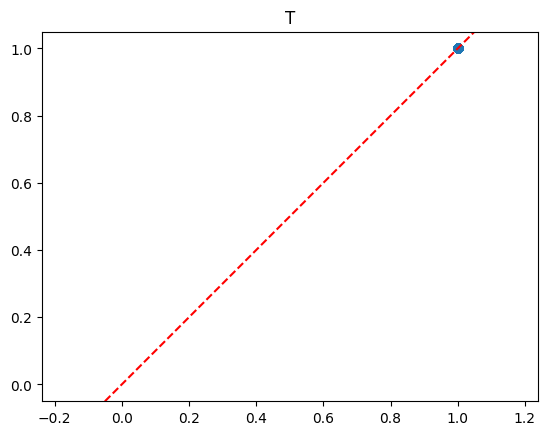

In [ ]:
plt.scatter(train_with_T1['T'], train_with_T1['T'])
plt.title('T')
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')

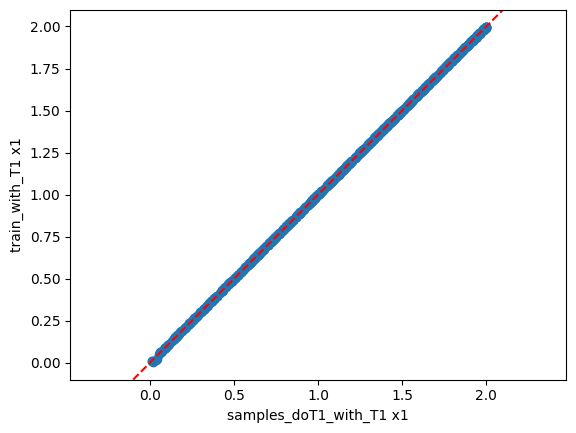

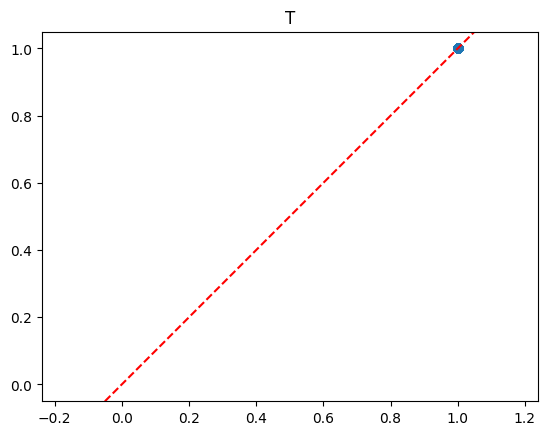

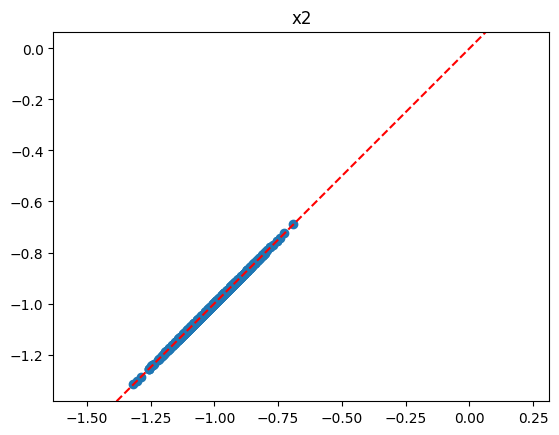

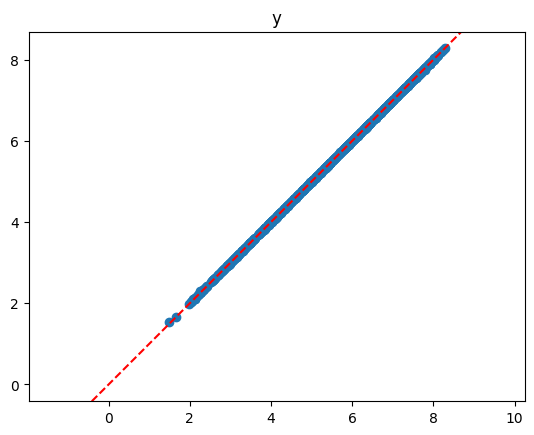

In [ ]:
from matplotlib import pyplot as plt

plt.scatter(samples_doT1_with_T1['x1'], train_with_T1['x1'])
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')
plt.xlabel('samples_doT1_with_T1 x1')
plt.ylabel('train_with_T1 x1')
plt.show()


plt.scatter(train_with_T1['T'], train_with_T1['T'])
plt.title('T')
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')
plt.show()

plt.title('x2')
plt.scatter(samples_doT1_with_T1['x2'], train_with_T1['x2'])
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')
plt.show()

plt.title('y')
plt.scatter(samples_doT1_with_T1['y'], train_with_T1['y'])
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')
plt.show()

In [ ]:
u_test_T0 = td_model.get_latent(test_df.iloc[idx_T0])
u_test_T1 = td_model.get_latent(test_df.iloc[idx_T1])


NameError: name 'idx_T0' is not defined

In [ ]:
df = np.array(test_df) #Fuck the 🐼
idx_T0 = df[df['T'] == 0]
idx_T1 = df[df['T'] == 1]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

[Warning] best_model.pt not found, falling back to initial_model.pt


/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <EA7F9DF5-8854-31D8-89D4-BD566CAF4DEA> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <B6BD92AE-4D03-3F92-9E03-2E2594A12866> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your e

[Warning] best_model.pt not found, falling back to initial_model.pt


/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <EA7F9DF5-8854-31D8-89D4-BD566CAF4DEA> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <B6BD92AE-4D03-3F92-9E03-2E2594A12866> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extens

[Warning] best_model.pt not found, falling back to initial_model.pt


/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <EA7F9DF5-8854-31D8-89D4-BD566CAF4DEA> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <B6BD92AE-4D03-3F92-9E03-2E2594A12866> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extens

[Warning] best_model.pt not found, falling back to initial_model.pt


/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <EA7F9DF5-8854-31D8-89D4-BD566CAF4DEA> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <B6BD92AE-4D03-3F92-9E03-2E2594A12866> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extens

[INFO] Final latent DataFrame shape: (2, 8)
[Warning] best_model.pt not found, falling back to initial_model.pt


/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <EA7F9DF5-8854-31D8-89D4-BD566CAF4DEA> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <B6BD92AE-4D03-3F92-9E03-2E2594A12866> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your e

[Warning] best_model.pt not found, falling back to initial_model.pt


/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <EA7F9DF5-8854-31D8-89D4-BD566CAF4DEA> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <B6BD92AE-4D03-3F92-9E03-2E2594A12866> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extens

[Warning] best_model.pt not found, falling back to initial_model.pt


/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <EA7F9DF5-8854-31D8-89D4-BD566CAF4DEA> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <B6BD92AE-4D03-3F92-9E03-2E2594A12866> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extens

[Warning] best_model.pt not found, falling back to initial_model.pt


/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <EA7F9DF5-8854-31D8-89D4-BD566CAF4DEA> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <B6BD92AE-4D03-3F92-9E03-2E2594A12866> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extens

[INFO] Final latent DataFrame shape: (8, 8)


### ITE vis CF 

In [ ]:
u_test_T0 = td_model.get_latent(test_df[test_df['T'] == 0])
u_test_T1 = td_model.get_latent(test_df[test_df['T'] == 1])


samples_cf_doT1, latents_doT1 = td_model.sample(do_interventions={'T':1.0}, predefined_latent_samples_df=u_test_T0)
samples_cf_doT0, latents_doT0 = td_model.sample(do_interventions={'T':0.0}, predefined_latent_samples_df=u_test_T1)

[INFO] Final latent DataFrame shape: (20, 8)


/Users/oli/Documents/GitHub/tramdag_py/.conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[INFO] Final latent DataFrame shape: (80, 8)
[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Interventions specified for nodes: ['T']
[INFO] Using predefined latents samples from dataframe -> therefore n_samples is set to the number of rows in the dataframe: 20
[INFO] Deleting all previously sampled data.
Deleted directory: exp_untrained/x1/sampling
Deleted directory: exp_untrained/T/sampling
Deleted directory: exp_untrained/x2/sampling
Deleted directory: exp_untrained/y/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x1 from dataframe column: x1_U


/Users/oli/Documents/GitHub/tramdag_py/.conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 2914.27it/s]

[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: T ------------*-----------------*-------------------*--
[INFO] Applying intervention for node 'T' with value 1.0
[INFO] Interventional data for node T is saved

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x2 from dataframe column: x2_U



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 2979.82it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: y ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node y from dataframe column: y_U



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 2896.46it/s]

[INFO] Completed sampling for node 'y'
[INFO] DAG sampling completed successfully for all nodes.
[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Interventions specified for nodes: ['T']
[INFO] Using predefined latents samples from dataframe -> therefore n_samples is set to the number of rows in the dataframe: 80
[INFO] Deleting all previously sampled data.
Deleted directory: exp_untrained/x1/sampling
Deleted directory: exp_untrained/T/sampling
Deleted directory: exp_untrained/x2/sampling
Deleted directory: exp_untrained/y/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x1 from dataframe column: x1_U



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 2654.40it/s]

[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: T ------------*-----------------*-------------------*--
[INFO] Applying intervention for node 'T' with value 0.0
[INFO] Interventional data for node T is saved

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x2 from dataframe column: x2_U



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 2695.79it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: y ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node y from dataframe column: y_U



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 2590.74it/s]

[INFO] Completed sampling for node 'y'
[INFO] DAG sampling completed successfully for all nodes.


In [ ]:
samples_cf_doT0

{'x1': tensor([1.6714, 1.8969, 0.5764, 0.4122, 0.9674, 1.9205, 1.9615, 1.7456, 0.8604,
         1.2331, 1.6789, 0.8149, 1.9348, 0.1252, 1.1762, 1.1884, 1.6218, 0.3359,
         1.7388, 0.2138, 0.1310, 1.3814, 1.3946, 1.1126, 1.0775, 0.0138, 1.1574,
         0.7984, 1.7540, 0.8520, 1.2303, 1.5145, 1.3852, 0.6575, 0.8223, 1.7537,
         0.1274, 0.3964, 0.7836, 0.5540, 1.8052, 1.2577, 0.5807, 1.1045, 1.2440,
         1.5266, 0.0136, 1.1927, 0.6945, 0.8770, 0.6160, 0.2435, 0.2321, 1.2888,
         1.8966, 1.1133, 1.2454, 1.7718, 1.6185, 0.8484, 0.9802, 1.4955, 1.1572,
         0.5732, 1.7204, 0.3618, 0.5245, 1.7155, 1.2943, 1.5508, 0.4511, 1.2292,
         1.4540, 1.3871, 1.1151, 0.5916, 0.9475, 1.8874, 1.1544, 0.2740]),
 'T': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [ ]:
# Definition of the ITE using the counterfactuals and the factual
# ITE_i = Y(T_i=1,X_i) - Y(T_i=0,X_i) #NB one is factual, the other is counterfactual

# First for the factual T=1
Y_factual_T1 = test_df[test_df['T'] == 1]['y']
# Counterfactual T=0
Y_counterfactual_T0 = samples_cf_doT0['y'].numpy().flatten()

# ITE_i = Y(T_i=1,X_i) - Y(T_i=0,X_i)
ITE = Y_factual_T1 - Y_counterfactual_T0
print("Factual T1 ITE.mean()",ITE.mean())

Y_factual_T0 = test_df[test_df['T'] == 0]['y']
Y_counterfactual_T1 = samples_cf_doT1['y'].numpy().flatten()
ITE_T0 = Y_counterfactual_T1 - Y_factual_T0
print("Factual T0 ITE.mean()",ITE_T0.mean())

Factual T1 ITE.mean() 3.7407201754230437
Factual T0 ITE.mean() 3.767995483509659


In [ ]:
ITE, ITE_T0







(436    3.758409
 899    3.714975
 346    3.751301
 60     3.712812
 867    3.776919
          ...   
 351    3.753736
 499    3.769681
 76     3.729612
 626    3.781745
 892    3.684822
 Name: y, Length: 80, dtype: float64,
 543    3.773942
 361    3.743560
 277    3.766131
 355    3.782655
 977    3.747342
 218    3.763031
 136    3.774185
 643    3.765999
 635    3.776034
 215    3.770445
 652    3.762582
 713    3.770330
 319    3.745760
 998    3.770644
 978    3.772806
 198    3.761319
 924    3.794124
 213    3.768175
 884    3.769011
 986    3.781835
 Name: y, dtype: float64)

In [ ]:
## TODO 
# n data trained
#  Train NLL
# td_model.nll(train_df)
# coefficient LS SI , 

#  

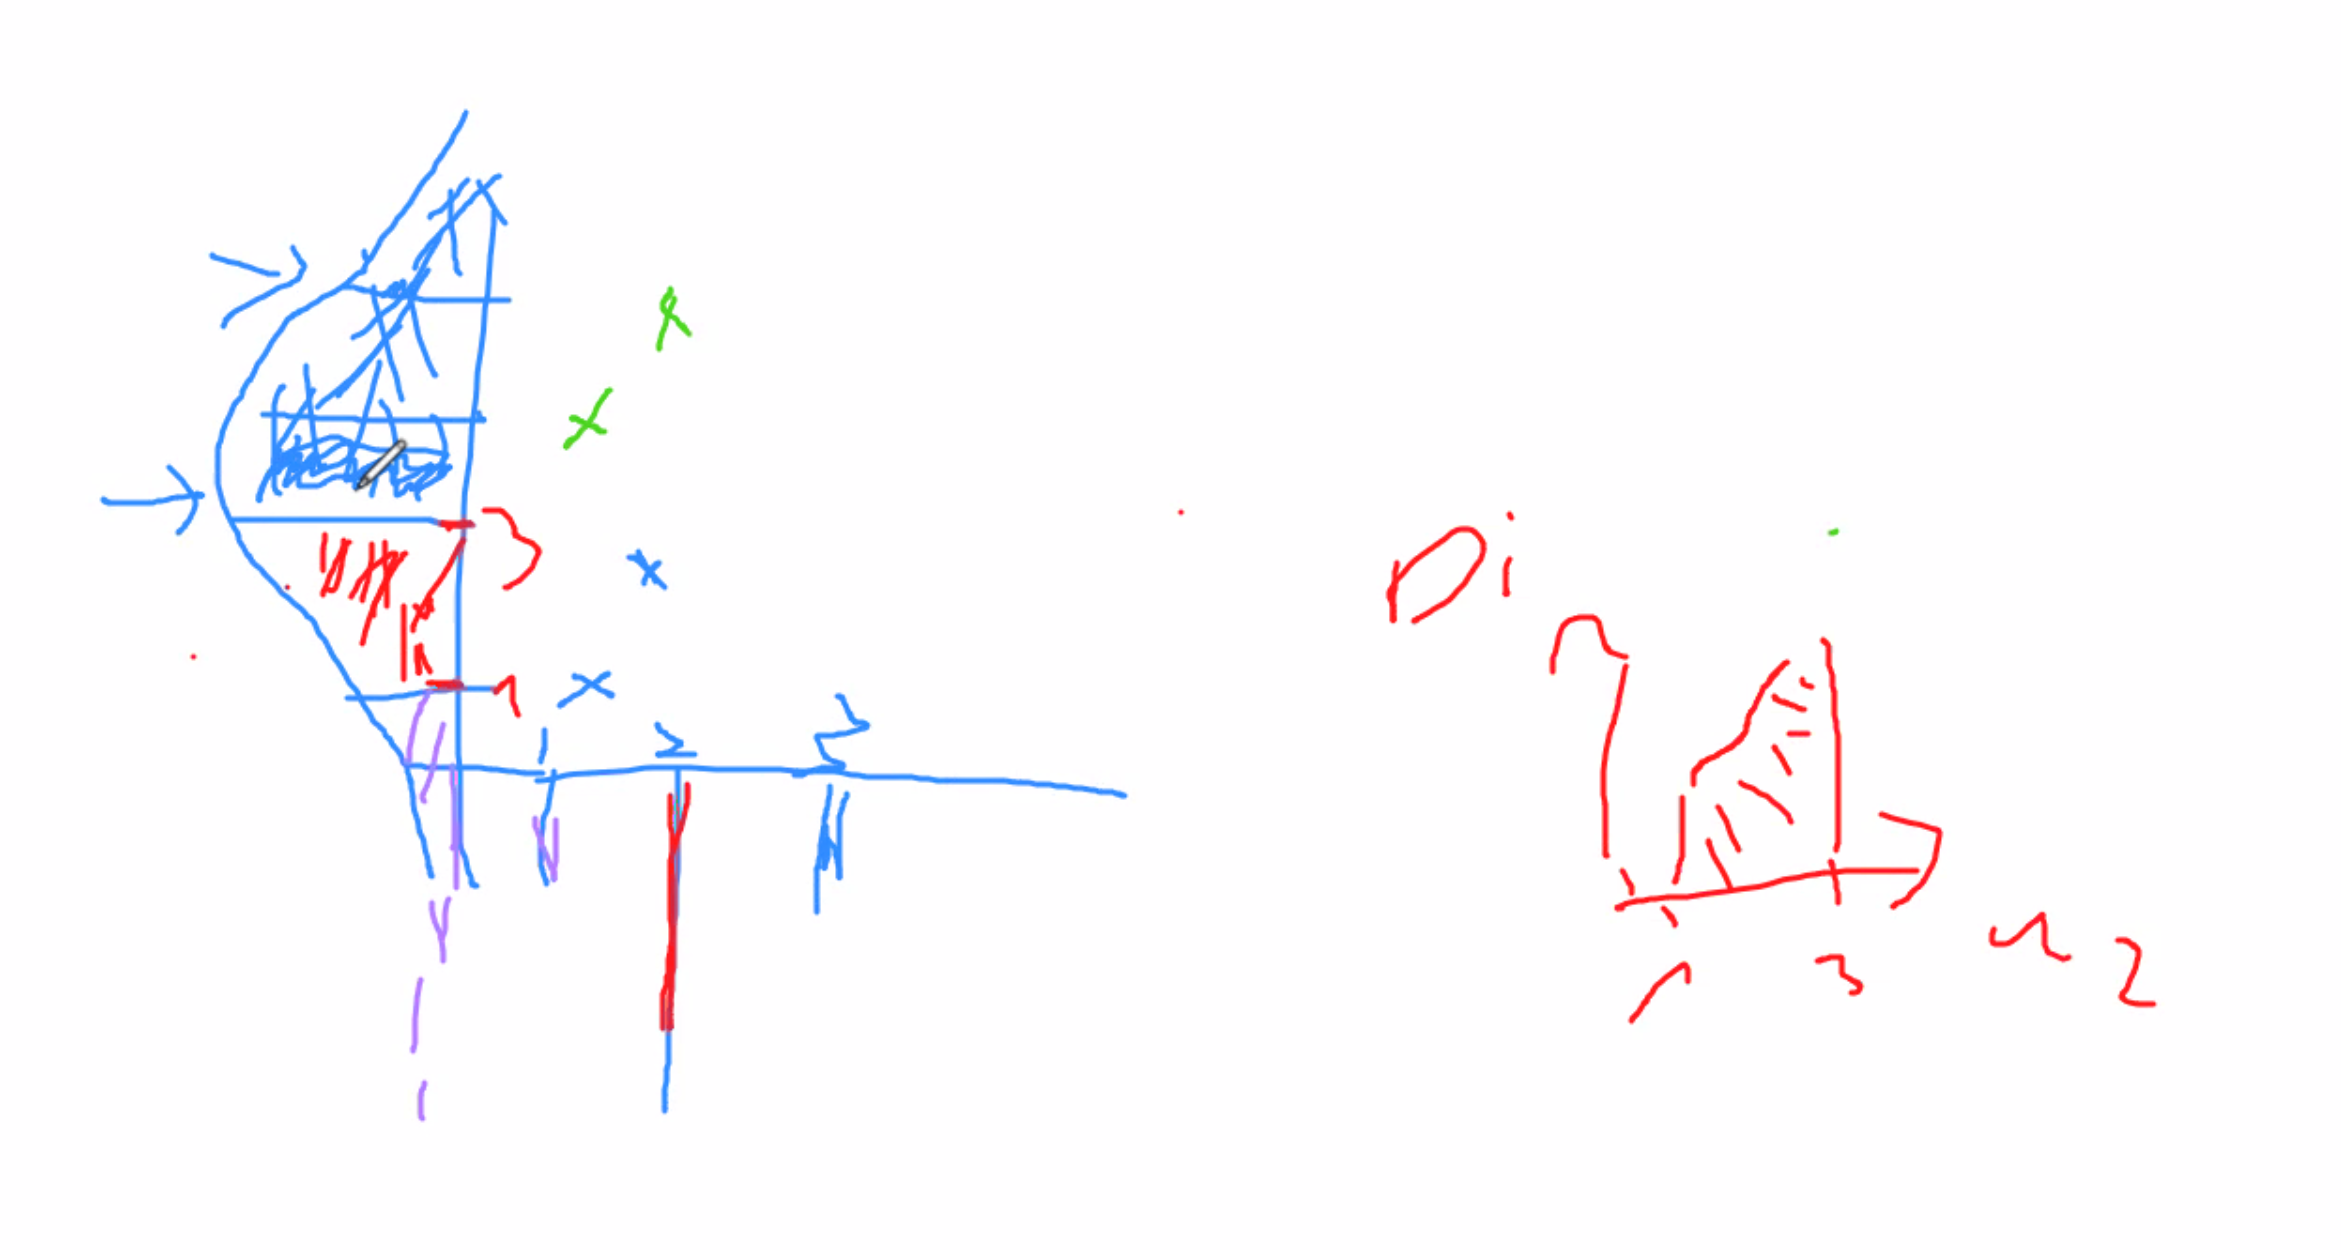